In [1]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Model:
    # Deterministic model

    def __init__(self, k, b):
        ''' y = k * x + b
            y = f(x | k, b)
            function of x for given (k, b) values
        '''
        self.k = k
        self.b = b

    def set_params(self, k, b):
        self.k = k
        self.b = b

    def evaluate(self, x):
        return self.k * x + self.b


K_TRUE = 1   # [m/N]
B_TRUE = 4   # [m]
model_true = Model(k=K_TRUE, b=B_TRUE)

In [3]:
class Experiment:
    # Stochastic model which takes in a deterministic model of spring extension
    # nuissence parameters

    def __init__(self, model):
        self.model = model
        self.sigma_err = 2   # [m]
        self.seed = 1  # summarizes the random state of the universe
        self.rng = np.random.default_rng(self.seed)

    def run(self, x_min, x_max, num_x, file_name):
        # min force, max force, num of measurements
        x_list = np.linspace(x_min, x_max, num_x)
        y_list = []
        sigma_list = []   # uncertainty of every measurement we made of every point
                          # they should not be nesceserily be equal
        for x in x_list:
            y = self.model.evaluate(x)
            # experiment model = model of spring + mode of noise
            # we model the noise as random values sampled from
            # the gaussian distribution

            # the error model is a gaussian distribution
            # the error model parameter that we choose is
            # sigma_error - the standard deviation of error
            # maybe uncertainty would be better name instead of error

            # y_err = np.random.normal(loc=0, scale=self.sigma_err)
            sigma_error = self.sigma_err
            y_err = self.rng.normal(loc=0, scale=sigma_error)
            y = y + y_err
            y_list.append(y)
            sigma_list.append(sigma_error)
        data = {
            'x': x_list,
            'y': y_list,
            'sigma': sigma_list,
        }
        df = pd.DataFrame(data)
        df.to_csv(file_name, index=False)


experiment = Experiment(model=model_true)
experiment.run(
    x_min=0,
    x_max=10,
    num_x=11,
    file_name='results.csv'
)

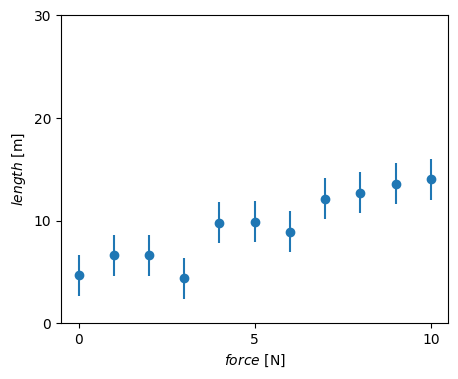

In [4]:
class Data:

    def __init__(self, file_name):
        self.df = pd.read_csv(file_name)

    def plot(self, y_model_true=None, y_model_fit=None):
        plt.figure(figsize=(5, 4))   # size in inches
        plt.errorbar(
            self.df.x,
            self.df.y,
            yerr=self.df.sigma,
            fmt='o'
        )
        if y_model_true:
            plt.plot(self.df.x, y_model_true, c='c')
        if y_model_fit:
            plt.plot(self.df.x, y_model_fit, c='r')
        plt.xlabel('$force$ [N]')
        plt.ylabel('$length$ [m]')
        plt.xticks([0, 5, 10])
        plt.yticks([0, 10, 20, 30])
        # TODO ticks inside and all sides
        plt.savefig('data.png', dpi=100)  # dots per inch


data = Data(file_name='results.csv')
data.plot()

In [5]:
# Optimizers: by eye, grid seach, random walker

# Loss functions:
# Mean squared error -> likelihood function

In [6]:
def mean_squared_error_loss(y_data, y_model):
    delta_y = y_data - y_model
    delta_y2 = delta_y**2
    return np.mean(delta_y2)

In [7]:
def compute_likelihood(y_data_list, y_model_list, sigma_err_list):
    return 0

100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


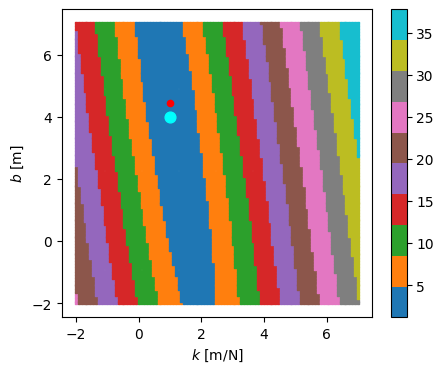

In [8]:
class GridSearchOptimizer:

    def __init__(self, data, model):
        self.data = data
        self.model = model
        self.k_list = []
        self.b_list = []
        self.loss_list = []
        self.idx_min = None

    def run(self, k_lim, b_lim, num_k, num_b):
        for k in tqdm.tqdm(np.linspace(k_lim[0], k_lim[1], num_k)):
            for b in np.linspace(b_lim[0], b_lim[1], num_b):
                self.model.set_params(k, b)
                y_model = self.model.evaluate(self.data.df.x)
                loss = mean_squared_error_loss(
                    y_data=self.data.df.y,
                    y_model=y_model
                )
                self.k_list.append(k)
                self.b_list.append(b)
                self.loss_list.append(loss)
        self.idx_min = np.argmin(self.loss_list)

    def plot(self):
        plt.figure(figsize=(5, 4))
        plt.scatter(
            self.k_list,
            self.b_list,
            c=np.sqrt(self.loss_list),
            cmap='tab10',
            s=2,
            marker='s',
            zorder=0
        )
        plt.colorbar()
        # model fit is red
        plt.scatter(
            self.k_list[self.idx_min],
            self.b_list[self.idx_min],
            s=20,
            c='r',
            zorder=2
        )
        # model true is cyan
        plt.scatter(
            K_TRUE,
            B_TRUE,
            s=60,
            c='cyan',
            zorder=1
        )
        plt.xlabel('$k$ [m/N]')
        plt.ylabel('$b$ [m]')
        # TODO add label for mean squard error units of measurement [m2]
        plt.savefig('param_grid.png', dpi=100)


model_to_fit = Model(k=0, b=0)
optimizer = GridSearchOptimizer(data=data, model=model_to_fit)
optimizer.run(
    k_lim=(-2, 7),   # ~3
    b_lim=(-2, 7),
    num_k=100,
    num_b=100,
)
optimizer.plot()

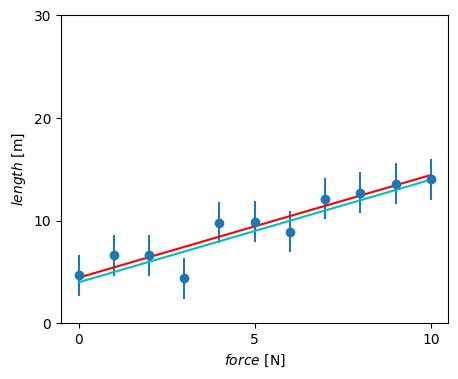

In [9]:
model_to_plot = Model(k=0, b=0)

model_to_plot.set_params(K_TRUE, B_TRUE)
y_model_true = model_to_plot.evaluate(data.df.x)

K_FIT = optimizer.k_list[optimizer.idx_min]
B_FIT = optimizer.b_list[optimizer.idx_min]
model_to_plot.set_params(K_FIT, B_FIT)
y_model_fit = model_to_plot.evaluate(data.df.x)

data.plot(
    y_model_true=list(y_model_true),
    y_model_fit=list(y_model_fit),
)


100%|██████████| 100/100 [00:03<00:00, 30.47it/s]


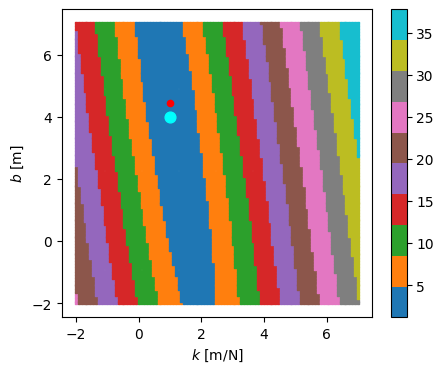

In [10]:
class RandomWalkerOptimizer:

    def __init__(self, data, model):
        # random walker optimizer
        # with grid search providing a map to
        # overplot
        self.data = data
        self.model = model
        # grid part
        self.k_list = []
        self.b_list = []
        self.loss_list = []
        # walker part
        self.k_walk_list = []
        self.b_walk_list = []
        self.likelihood_walk_list = []
        self.idx_min = None
        self.num_accepted = 0
        self.num_rejected = 0

    def walk(self, k_start, b_start, num_steps):
        k_now = k_start
        b_now = b_start
        # loss_now = np.inf   #initially largest number - infinity
        likelihood_now = -np.inf

        for step in range(num_steps):
            k_step = np.random.uniform(-0.1, 0.1)   # TODO finetune
            b_step = np.random.uniform(-0.1, 0.1)   # TODO

            # trial step
            k_test = k_now + k_step
            b_test = b_now + b_step
            self.model.set_params(k_test, b_test)
            y_model = self.model.evaluate(self.data.df.x)


            # loss_test = mean_squared_error_loss(
            #     y_data=self.data.df.y,
            #     y_model=y_model
            # )

            likelihood_test = compute_likelihood(
                y_data_list=self.data.df.y,
                y_model_list=y_model,
                sigma_err_list=self.data.df.sigma,
            )

            # if loss_test < loss_now:
                # if going downhill, accept the trial step

            if likelihood_test > likelihood_now:
                k_now = k_test
                b_now = b_test
                # loss_now = loss_test
                likelihood_now = likelihood_test
                self.k_walk_list.append(k_now)
                self.b_walk_list.append(b_now)
                self.likelihood_walk_list.append(likelihood_now)
                self.num_accepted += 1
            else:
                self.num_rejected += 1

    def run(self, k_lim, b_lim, num_k, num_b):
        for k in tqdm.tqdm(np.linspace(k_lim[0], k_lim[1], num_k)):
            for b in np.linspace(b_lim[0], b_lim[1], num_b):
                self.model.set_params(k, b)
                y_model = self.model.evaluate(self.data.df.x)
                loss = mean_squared_error_loss(
                    y_data=self.data.df.y,
                    y_model=y_model
                )
                self.k_list.append(k)
                self.b_list.append(b)
                self.loss_list.append(loss)
        self.idx_min = np.argmin(self.loss_list)

    def plot(self):
        plt.figure(figsize=(5, 4))
        plt.scatter(
            self.k_list,
            self.b_list,
            c=np.sqrt(self.loss_list),
            cmap='tab10',
            s=2,
            marker='s',
            zorder=0
        )
        plt.colorbar()
        # model fit is red
        plt.scatter(
            self.k_list[self.idx_min],
            self.b_list[self.idx_min],
            s=20,
            c='r',
            zorder=2
        )
        # model true is cyan
        plt.scatter(
            K_TRUE,
            B_TRUE,
            s=60,
            c='cyan',
            zorder=1
        )
        plt.plot(
            self.k_walk_list,
            self.b_walk_list,
            c='red',
            zorder=9999
        )
        plt.xlabel('$k$ [m/N]')
        plt.ylabel('$b$ [m]')
        # TODO add label for mean squard error units of measurement [m2]
        plt.savefig('param_walk.png', dpi=100)

model_to_fit = Model(k=0, b=0)
optimizer_walker = RandomWalkerOptimizer(data=data, model=model_to_fit)
optimizer_walker.run(  # for now it gives grid for us
    k_lim=(-2, 7),   # ~3
    b_lim=(-2, 7),
    num_k=100,
    num_b=100,
)
optimizer_walker.walk(
    k_start=6,
    b_start=0,
    num_steps=1000,
)
optimizer_walker.plot()

In [11]:
optimizer_walker.num_accepted

1

In [12]:
optimizer_walker.num_rejected

999

In [13]:
# acceptance fraction should be ~50%